# Neumann Boundary Condition

In [1]:
%load_ext autoreload
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import sys
import os
# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
# from hippylib import *
import logging
# sys.path.append('utils')
import math
import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'NBC'
omega = 10
oce_val = 0
gamma =3e-8

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

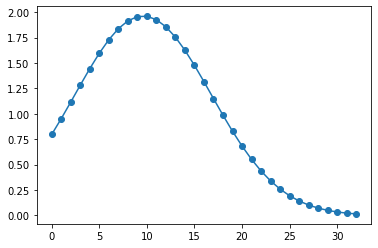

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.show()

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 1.0#cos(0.0)*3*pi
u0R = 0.1 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 1.0, u0R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

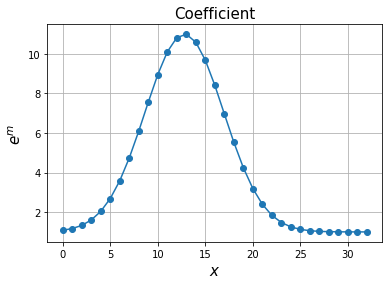

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

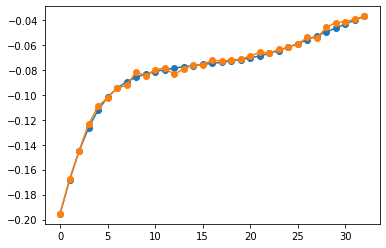

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values(),normalize = False)

plt.plot(utrue_array, 'o-')
plt.plot(run.ud.compute_vertex_values(), 'o-')
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)

u,_,_ = run.fwd_solve(m)
print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax())
print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax())

0.487470582321186
0.05003529874780799


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     5.98540e-05   1.19708e-04   4.13175e-10   2.00753e-02   7.43249e-04   1.00e+00   5.000e-01
 2     1     4.58907e-05   9.17811e-05   2.46870e-10   4.76119e-03   1.75278e-04   1.00e+00   4.856e-01
 3     3     6.77250e-06   1.30168e-05   5.28165e-07   7.48885e-03   1.28996e-04   1.00e+00   4.166e-01
 4     1     5.34642e-06   1.01636e-05   5.29241e-07   1.73473e-03   6.90315e-05   1.00e+00   3.048e-01
 5     3     1.62463e-06   2.35646e-06   8.92806e-07   2.69254e-03   6.04510e-05   1.00e+00   2.852e-01
 6     2     1.59435e-06   2.29607e-06   8.92621e-07   2.42948e-04   8.47685e-06   1.00e+00   1.068e-01
 7    15     1.40149e-06   1.77679e-06   1.02618e-06   6.12673e-04   5.34385e-06   1.00e+00   8.479e-02
 8     2     1.39325e-06   1.76057e-06   1.02592e-06   1.27480e-04   3.40266e-06   1.00e+00   6.766e-02
 9    16     1.38433e-06   1.72091e-06   1.04776e-06   1.26843e-04   8.

## Plot Results

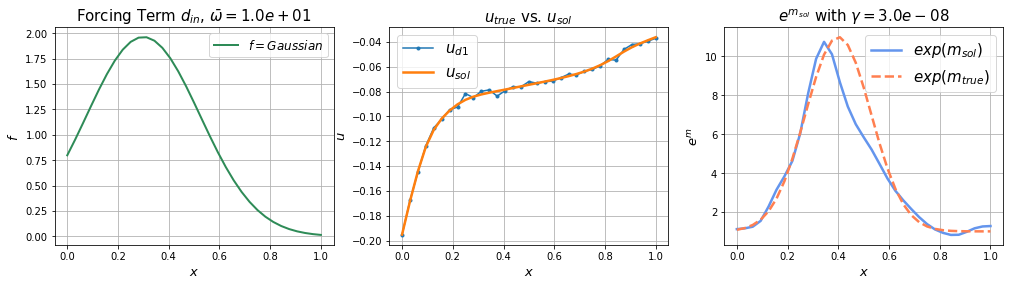

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./img/helm_NB_synth_2result2.eps', format='eps',dpi=250)
plt.show()

# Dirichlet Boundary Condition

In [1]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import sys
import os
# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
# from hippylib import *
import logging
# sys.path.append('utils')
import math
import matplotlib.pyplot as plt


## Initialization

In [2]:
nx = 32
a,b = 0,1
bc_type = 'DBC'
omega = 10
oce_val = 0.0
gamma =3e-5

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx+self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx'
a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Forcing Term

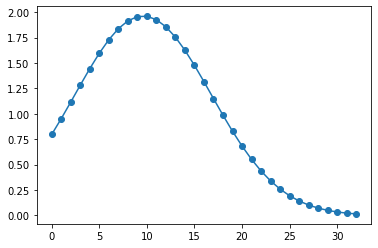

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u0L = 0.0#cos(0.0)*3*pi
u0R = 1.0 #cos(3*pi)*3*pi
print(f'u0L: {u0L}, u0R: {u0R}')
run.BC_setup(u0L, u0R)

u0L: 0.0, u0R: 1.0


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

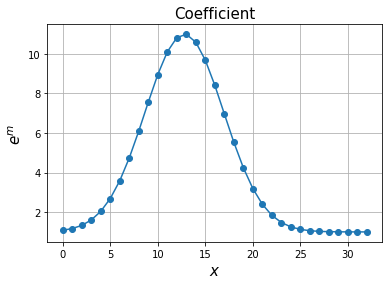

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

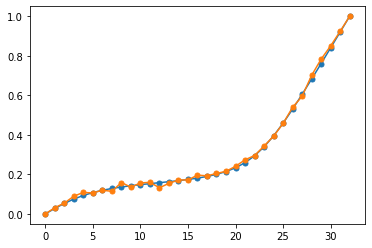

In [6]:
np.random.seed(0)
noise_level = 0.01
ud, goal_A, goal_b = run.fwd_solve(m)
utrue_array = ud.compute_vertex_values()
from utils.general import apply_noise
apply_noise(noise_level, ud, goal_A)
run.data_setup(ud_array = ud.compute_vertex_values())

plt.plot(utrue_array, 'o-',markersize=5)
plt.plot(run.ud.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
print(u.compute_vertex_values()[0])
print(u.compute_vertex_values()[-1])

0.0
1.0


## Optimization Loop

In [8]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
0.005840933345307978
 1     1     1.75362e-03   3.48909e-03   1.81405e-05   1.15103e-01   3.37827e-02   1.00e+00   5.000e-01
0.0014726737490585395
 2     2     7.85145e-04   1.40428e-03   1.66010e-04   4.57876e-02   8.44484e-03   1.00e+00   5.000e-01
0.0008779279484898755
 3     1     6.64292e-04   1.17679e-03   1.51790e-04   1.54948e-02   5.52185e-03   1.00e+00   4.043e-01
0.0004996602364536021
 4     2     3.56893e-04   3.03443e-04   4.10344e-04   2.50671e-02   2.80898e-03   1.00e+00   2.884e-01
0.0001603230597258279
 5     2     3.43724e-04   2.66141e-04   4.21306e-04   5.03947e-03   9.47733e-04   1.00e+00   1.675e-01
0.000153621167688086
 6     4     3.32006e-04   2.11172e-04   4.52840e-04   4.84633e-03   4.08099e-04   1.00e+00   1.099e-01
0.00014883128468798262
 7     4     3.31946e-04   2.13801e-04   4.50091e-04   3.36969e-04   3.73623e-05   1.00e+00   3.326e-02
0.00015179660539955177

## Plotting Results

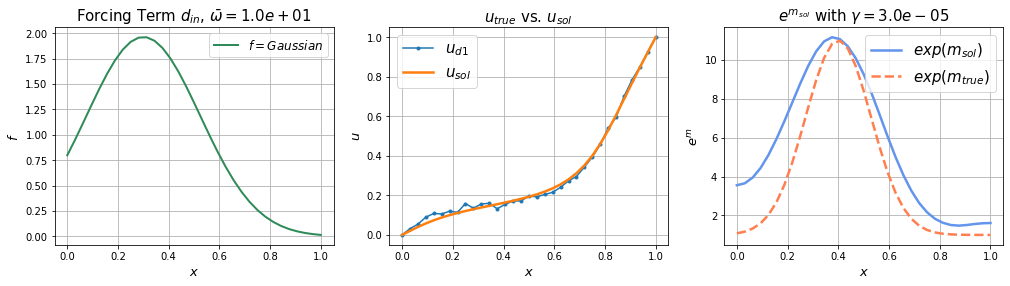

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$f$', fontsize=13)
ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# ax[0].legend()
ax[0].legend(prop={'size':12})

ax[1].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[1].plot(x, u.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./img/helm_NB_synth_2result2.eps', format='eps',dpi=250)
plt.show()

# Dual Data Problem

In [1]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl
import numpy as np

import sys
import os
# sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
# sys.path.append('utils')
import math

import matplotlib.pyplot as plt

## Initialization

In [2]:
nx = 32
a,b = 0,1
omega = 10
oce_val1 = 0.0
oce_val2 = 0.0
gamma =3e-6

beta1 = 1.0
beta2 = 1.0

run = dual_data_run(nx, a, b, gamma, omega, omega, oce_val1, oce_val2, normalized_mean1=oce_val1,normalized_mean2=oce_val2, beta1=beta1, beta2 = beta2)
x = run.mesh.coordinates()

## Forcing Term

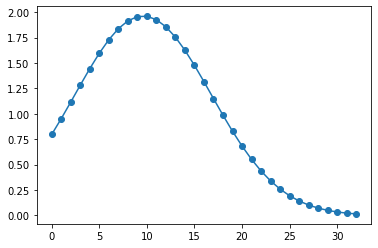

In [3]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boundary Condition

In [4]:
from numpy import cos, pi, sin, exp
u1L_D = 0.0#cos(0.0)*3*pi
u1R_D = 1.0 #cos(3*pi)*3*pi
u2L_N = 1.0
u2R_N = 0.1
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D}, NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

Dirichlet_L: 0.0, Dirichlet_R: 1.0, NBC_L: 1.0, NBC_R: 0.1


## $m_{true}$

Text(0.5, 1.0, 'Coefficient')

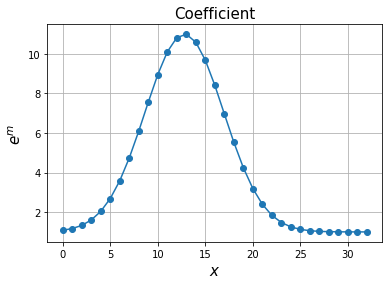

In [5]:
# The true and inverted parameter
peak_loc = 0.4
gauss_var = 30
mtrue_expression_str = f'std::log(1.+ 10.*std::exp(-pow(x[0] - {peak_loc}, 2) * {gauss_var}))'
# mtrue_expression_str = 'std::x[0]*sin(x[0])'
mtrue_expression = dl.Expression(mtrue_expression_str, degree=5)
mtrue = m =  dl.interpolate(mtrue_expression,run.Vm)

# mtrue = dl.Function(Vm)
# mtrue.vector().set_local(m_func[::-1,...])
plt.plot(np.exp(mtrue.compute_vertex_values()), 'o-')
plt.grid()
plt.xlabel(r'$x$', fontsize=15)
plt.ylabel(r'$e^{m}$', fontsize=15)
plt.title('Coefficient',fontsize=15)

## Setup Data

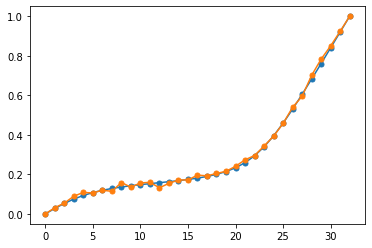

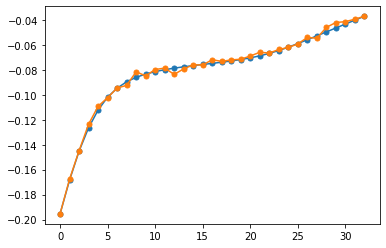

In [6]:

noise_level = 0.01
ud1, ud2, goal_A1, goal_b1, goal_A2, goal_b2 = run.fwd_solve(m)
utrue1_array = ud1.compute_vertex_values()
utrue2_array = ud2.compute_vertex_values()
from utils.general import apply_noise
np.random.seed(0)
apply_noise(noise_level, ud1, goal_A1)
np.random.seed(0)
apply_noise(noise_level, ud2, goal_A2)
run.data_setup(ud1.compute_vertex_values(), ud2.compute_vertex_values(),normalize=False)

plt.plot(utrue1_array, 'o-',markersize=5)
plt.plot(run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
plt.plot(utrue2_array, 'o-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Initial Guess and Initial Solution

In [7]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(2)", degree=1),run.Vm)
# m.assign(mtrue)
# m = mtrue

u1,u2,_,_,_,_ = run.fwd_solve(m)
print(u1.compute_vertex_values()[0])
print(u1.compute_vertex_values()[-1])
print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())

0.0
1.0
0.487470582321186
0.05003529874780799


## Optimization Loop

In [8]:
tol = 1e-11
c = 1e-4
maxiter=100
m, u1, u2 = run.opt_loop(m, tol, c, maxiter)

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.75296e-03   5.50412e-03   1.80988e-06   1.11142e-01   3.39685e-02   1.00e+00   5.000e-01
 2     1     8.57099e-04   1.69765e-03   1.65465e-05   9.80112e-02   1.01321e-02   5.00e-01   5.000e-01
 3     1     7.29875e-04   1.44533e-03   1.44170e-05   1.57288e-02   4.86906e-03   1.00e+00   3.786e-01
 4     3     1.33187e-04   2.08640e-04   5.77340e-05   3.29601e-02   2.73692e-03   1.00e+00   2.839e-01
 5     6     7.48527e-05   6.32531e-05   8.64523e-05   1.11519e-02   9.94627e-04   1.00e+00   1.711e-01
 6     2     7.35222e-05   6.02986e-05   8.67459e-05   1.63150e-03   4.49303e-04   1.00e+00   1.150e-01
 7    10     7.06160e-05   5.35975e-05   8.76344e-05   2.43661e-03   1.89820e-04   1.00e+00   7.475e-02
 8    10     7.05853e-05   5.31665e-05   8.80040e-05   2.47971e-04   2.73202e-05   1.00e+00   2.836e-02
 9    16     7.05851e-05   5.31158e-05   8.80543e-05   1.90593e-05   1.

## Plotting Results

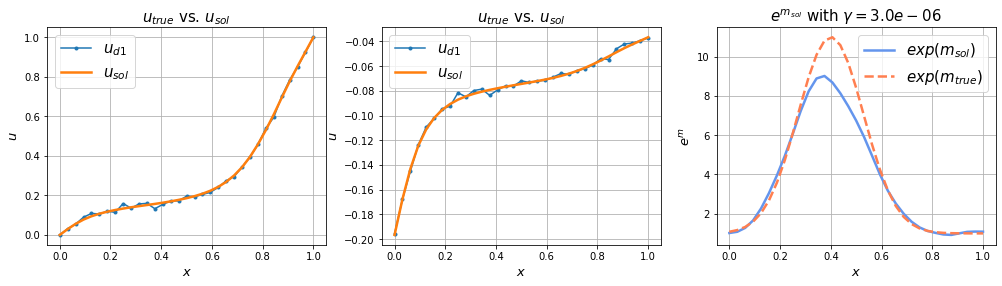

In [9]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

ax[0].plot(x, run.ud1.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[0].plot(x, u1.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[0].legend(prop={'size':15})

ax[1].plot(x, run.ud2.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=3)
ax[1].plot(x, u2.compute_vertex_values(), '', label=r'$u_{sol}$',linewidth=2.5)
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$u$', fontsize=13)
ax[1].set_title(r'$u_{true}$ vs. $u_{sol}$', fontsize=15)
ax[1].legend(prop={'size':15})

text = ax[2].yaxis.get_offset_text()
text.set_fontsize(8)
ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
ax[2].plot(x, np.exp(mtrue.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
ax[2].grid('on')
ax[2].set_xlabel(r'$x$', fontsize=13)
ax[2].set_ylabel(r'$e^m$', fontsize=13)
ax[2].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[2].legend(prop={'size':15})

# plt.savefig(f'./img/helm_NB_synth_2result2.eps', format='eps',dpi=250)
plt.show()